In [45]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from src.graph import NeighborsGraph
from tqdm import tqdm

In [61]:
graph = NeighborsGraph.load('../data/dataset/dataset_graph.pkl')

def add_graph_info(results_df:pd.DataFrame, graph:NeighborsGraph):

    graph_info_df = list()
    for id_ in tqdm(results_df.index, 'add_graph_info'):
        neighbor_distances = graph.get_neighbor_distances(id_)
        graph_info = dict()
        graph_info['mean_distance_to_neighbors'] = np.mean(neighbor_distances)
        graph_info['min_distance_to_neighbors'] = np.min(neighbor_distances)
        graph_info['max_distance_to_neighbors'] = np.max(neighbor_distances)
        graph_info['neighbor_ids'] = ','.join(graph.get_neighbor_ids(id_))
        graph_info_df.append(graph_info)
    graph_info_df = pd.DataFrame(graph_info_df, index=results_df.index)
    results_df = results_df.merge(graph_info_df, right_index=True, left_index=True)
    return results_df

In [62]:
model_name = 'model_v2'

annotated_results_df = pd.read_csv('../data/results/dataset_false_negative_annotated.csv', index_col=0)

mislabeled_ids = annotated_results_df[annotated_results_df.category.str.contains('error')].index

train_results_df = pd.read_csv('../data/results/dataset_train_predict.csv', index_col=0).assign(dataset='train')
test_results_df = pd.read_csv('../data/results/dataset_test_predict.csv', index_col=0).assign(dataset='test')

results_df = pd.concat([train_results_df, test_results_df])
results_df = results_df.rename(columns={f'{model_name}_output_0':'model_output_0', f'{model_name}_output_1':'model_output_1', f'{model_name}_label':'model_label'})[['model_label', 'model_output_0', 'model_output_1', 'dataset']].copy()
results_df = results_df.merge(pd.read_csv('../data/dataset/dataset.csv', index_col=0), left_index=True, right_index=True)
results_df['category'] = results_df.index.map(annotated_results_df.category).fillna('none')
results_df = add_graph_info(results_df, graph)

add_graph_info: 100%|██████████| 276590/276590 [01:07<00:00, 4073.03it/s]


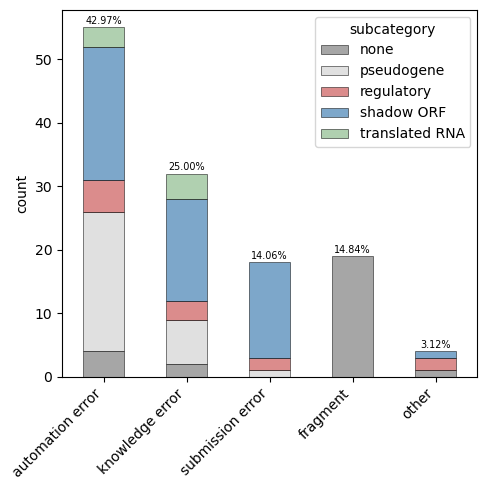

In [40]:
def figure(results_df:pd.DataFrame, threshold:float=0.95):

    results_df['model_label'] = np.where(results_df.model_output_0 > threshold, 0, 1)
    results_df = results_df[(results_df.model_label == 0) & (results_df.label == 1)].copy() # Get all false positives. 
    results_df = results_df[results_df.category.str.contains('error') | results_df.category.str.contains('fragment')]

    n = len(results_df)

    fig, ax = plt.subplots(figsize=(5, 5))

    ax_df = pd.DataFrame(index=results_df.index)

    categories = ['automation error','knowledge error',  'submission error', 'fragment', 'other']
    subcategories = ['pseudogene', 'shadow ORF', 'regulatory', 'translated RNA', 'none']

    palette = {'pseudogene':'lightgray', 'shadow ORF':'steelblue', 'regulatory':'indianred', 'translated RNA':'darkseagreen', 'none':'gray'}
    ax_df['category'] = np.select([results_df.category.str.contains(category) for category in categories], categories, default='other')
    ax_df['subcategory'] = np.select([results_df.category.str.contains(category) for category in subcategories], subcategories, default='none')
    ax_df['count'] = 1
    ax_df = ax_df.pivot_table(index='category', columns='subcategory', values='count', aggfunc='sum', fill_value=0).loc[categories]
    ax_df.plot(kind='bar', stacked=True, color=palette, edgecolor='black', lw=0.5, ax=ax, alpha=0.7)
    ax.set_xticks(np.arange(len(categories)), labels=categories, ha='right', rotation=45)
    ax.set_xlabel('')
    ax.set_ylabel('count')

    heights = ax_df.sum(axis=1)
    for x, y in zip(np.arange(len(categories)), heights):
        ax.text(x, y + 0.5, f'{100 * y / n:.2f}%', ha='center', fontsize='x-small')

    fig.tight_layout()
    plt.show()

figure(results_df)



In [137]:
# Want to focus on the sequences which don't have a very nearby neighbor in embedding space, as it won't be productive 
# to look at sequences with very close homologs. 

def count_neighbors(neighbor_ids, label:int=0):
    neighbor_ids = neighbor_ids.split(',')
    return (results_df.loc[neighbor_ids].label == label).sum()

def table(results_df:pd.DataFrame, min_distance_to_nearest_neighbor:float=30):
    df = results_df[results_df.min_distance_to_neighbors > min_distance_to_nearest_neighbor].copy()
    # df.loc[np.intersect1d(mislabeled_ids, df.index), 'label'] = 0
    df['n_neighbors_spurious'] = df.neighbor_ids.apply(lambda ids : count_neighbors(ids, label=0))
    df['n_neighbors_real'] = df.neighbor_ids.apply(lambda ids : count_neighbors(ids, label=1))
    df['n_neighbors_same_label']= [row.n_neighbors_spurious if (row.label == 0) else row.n_neighbors_real for row in df.itertuples()]
    df['length'] = df.seq.apply(len)
    n_total, n_real, n_spurious = len(df), (df.label == 1).sum(), (df.label == 0).sum()

    table_df = pd.DataFrame(index=['real', 'spurious', 'total'])
    for n in range(1, 6):
        df_ = df[df.n_neighbors_same_label < n]
        table_df[f'< {n}'] = [f'{(100 * (df_.label == 1).sum() / n_real):.2f}%', f'{(100 * (df_.label == 0).sum() / n_spurious):.2f}%', f'{100 * len(df_) / n_total:.2f}%']
    table_df['total'] = [n_real, n_spurious, n_total]
    return table_df, df[(df.label == 1) & (df.n_neighbors_spurious > 3)].index

table_df, suspect_ids = table(results_df)
table_df

,< 1,< 2,< 3,< 4,< 5,total
real,2.46%,4.01%,5.61%,7.11%,11.87%,1870
spurious,2.52%,4.03%,7.06%,10.92%,27.56%,595
total,2.47%,4.02%,5.96%,8.03%,15.66%,2465


In [148]:
df = results_df.loc[suspect_ids]
df['length'] = df.seq.apply(len)
df[df.model_output_1 < 0.5][['length', 'non_terminal_residue', 'existence', 'product', 'category']]

,length,non_terminal_residue,existence,product,category
id,,,,,
P21322,104,none,predicted,Protein ORFh in retron Ec67,"submission error, shadow ORF"
A0A1M6T247,65,none,predicted,Precursor peptide TigB,"smORF, confirmed"
P14310,71,none,predicted,Uncharacterized 7.9 kDa protein in fixW 5'region,none
P39351,109,none,predicted,Uncharacterized protein YjgZ,conserved
B3A0L2,19,none,evidence at protein level,Antimicrobial peptide GP-19,none
P03852,132,none,predicted,Uncharacterized 15.3 kDa protein,none
P81786,23,23,evidence at protein level,Aldehyde dehydrogenase,none
C0HLL8,49,49,evidence at protein level,Glutathione peroxidase,none
P81720,37,37,evidence at protein level,Protease 2 large chain,none
